In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import math
import seaborn as sns
import scipy as sci
import matplotlib.pyplot as plt
import scikit_posthocs as sci_posthocs

import analysis as ana

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('display.max_colwidth', -1)

/tmp/ipykernel_23636/3464308124.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [4]:
import matplotlib as mpl
from matplotlib import rc

rc('text', usetex=False)
font = {'family':'CMU Serif', 
               #'sans-serif':['Helvetica'],
               'size': 11}
mpl.rc('font', **font)

# Preparation of Dataframe

In [5]:
path = '../../earlypsychosis/data/behavior/Package_1192721/'

In [6]:
features = pd.read_csv('../features_cog.csv')
features['file'] = features['file'].str.strip()
features['item'] = features['item'].str.strip()
len(features)

73

In [7]:
brain_data = pd.read_csv('../../earlypsychosis/anaBrain/brain_data_residual_cor.csv',  sep="\t", index_col=0, decimal=",", dtype={"HCP_ID": np.int32})

In [8]:
socdem = pd.read_csv(path + 'socdem01.txt', sep="\t")
ses = pd.read_csv(path + 'ses01.txt', sep="\t")

## Description

In [9]:
df_description = pd.DataFrame()

In [10]:
df_description["interview_age"] = [socdem['interview_age'].iat[0]]
df_description["sex"] = [socdem['sex'].iat[0]]
df_description["sestot"] = [ses['sestot'].iat[0]]
df_description["mot_edscale"] = [ses['mot_edscale'].iat[0]]

for file, columns in features.groupby('file'):
    columns = [col.strip() for col in list(columns.item)]
    data = pd.read_csv(path + file + '.txt', sep="\t")
    data = data[columns] #selecting relevant feature colums
    data = data.add_prefix(file + '_')
    
    for column in data:
        df_description[column] = [data[column].iat[0]]

In [11]:
df_description = df_description.T
df_description['included'] = [0]*77

In [12]:
#print(df_description.to_latex(index=True))  

### demographics 

sestot 1::5
1 = SES score of 08 to 19;
2 = SES score of 20 to 29;
3 = SES score of 30 to 39;
4 = SES score of 40 to 54;
5 = SES score of 55 to 66 

mot_edscale, fat_edscale 1::7;9
1 = Graduate Professional Training (completed a graduate level degree); 
2 = College or University (completed a four year degree); 
3 = Partial College Training (completed at least one year but have not completed a four year degree); 
4 = High School Graduation or GED; 
5 = Completed the 10th or 11th grades; 
6 = Completed 7th through the 9th grades; 
7 = Less than seven years of school; 
9 = Unknown 

In [13]:
socdem = socdem.drop_duplicates(subset=['subjectkey'], keep='first').iloc[1:]  # drop dublicates and remove description
socdem['src_subject_id'] = socdem['src_subject_id'].astype(int)
socdem['interview_age'] = socdem['interview_age'].astype(float)
socdem = socdem.set_index('src_subject_id')  # set index 

In [14]:
ses = ses.drop_duplicates(subset=['subjectkey'], keep='first').iloc[1:]  # drop dublicates and remove description
ses['src_subject_id'] = ses['src_subject_id'].astype(int)
ses['sestot'] = ses['sestot'].astype(float)
ses['mot_edscale'] = ses['mot_edscale'].astype(float).replace(to_replace=9, value=np.nan)
ses = ses.set_index('src_subject_id')  # set index 

### Building Dataframe

In [15]:
ndar_subject = pd.read_csv(path + 'ndar_subject01.txt', sep="\t")
ndar_subject = ndar_subject.drop_duplicates(subset=['subjectkey'], keep='first').iloc[1:]  # drop dublicates and remove description
#ndar_subject['src_subject_id'] = ndar_subject['src_subject_id'].str.strip()
ndar_subject['src_subject_id'] = ndar_subject['src_subject_id'].astype(int)
ndar_subject = ndar_subject.set_index('src_subject_id')  # set index 

In [16]:
df_start_index = brain_data.index.intersection(ndar_subject.index)  # subjets for which brain data is avalible
df_start = ndar_subject.loc[df_start_index, ['phenotype', 'phenotype_description']]

In [17]:
df_start = df_start.join(socdem[['sex', 'interview_age']], how='left')
df_start = df_start.join(ses[['sestot', 'mot_edscale']], how='left')

In [18]:
def replace_acpt01(df):
    feature_frame = pd.read_csv(path + 'acpt01.txt', sep="\t")
    feature_frame= feature_frame.drop(index=feature_frame.index[0])
    
    for index, row in df.iterrows():
        if not math.isnan(row['acpt01_auditory_t1']) and math.isnan(row['acpt01_auditory_t4']):
            df['acpt01_auditory_t4'][index] = df['acpt01_auditory_t1'][index]/24*100

In [19]:
def convert(data, phenotype_description_only=False):
    di = {'In good health': 0, 'Affective psychosis': 1, 'Non-affective psychosis': 2}
    data['phenotype_description'].replace(di, inplace=True)
    
    if not phenotype_description_only:
        data['phenotype'] = data["phenotype"].isin(['Patient']) #False = Control; True = Patient
        data['phenotype'] = data['phenotype'].astype(int)       #0 = Control; 1 = Patient

        data['sex'] = data['sex'].isin(['F']) #False = M, True = F
        data['sex'] = data['sex'].astype(int) #0 = male; 1 = female

In [20]:
def read_feature_frame(file):
    feature_frame = pd.read_csv(path + file + '.txt', sep="\t").replace(to_replace=str(999), value=np.nan)
    feature_frame = feature_frame.drop(index=feature_frame.index[0])  # remove description
    feature_frame['src_subject_id'] = feature_frame['src_subject_id'].astype(int)
    feature_frame = feature_frame.set_index('src_subject_id')
    
    return feature_frame

In [21]:
def load_all_features(df, features):

    for file, columns in features.groupby('file'):
        columns = [col.strip() for col in list(columns.item)]  # list of all features for a specific file
        data = read_feature_frame(file.strip())  # reading .txt file
        data = data[columns] #selecting relevant feature colums
        data = data.add_prefix(file + '_') #make it differentiable if same feature name
        for column in data:
            data[column] = data[column].astype(float)
        df = df.join(data, how='left') #rsuffix="_" + file #joining w.r.t.subjectkey, How -> SQL left, inner etc. rsuffix="_" filename after feature if feature name double
        
    # replace NaN with 0 in auditory False; exepction: when other auditory features nonexisting
    for hit, false in zip(['acpt01_auditory_t1', 'acpt01_auditory_t6', 'acpt01_auditory_t11'], ['acpt01_auditory_t3', 'acpt01_auditory_t8', 'acpt01_auditory_t13']):
            for index, row in df.iterrows():
                if not math.isnan(row[hit]) and math.isnan(row[false]):
                    df[false][index] = 0
            
    return df

In [22]:
df_cog = load_all_features(df_start, features)
replace_acpt01(df_cog)
convert(df_cog)

In [23]:
df_cog.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 1001 to 4024
Columns: 79 entries, phenotype to ymrs01_ymrstot
dtypes: float64(76), int64(3)
memory usage: 115.3 KB


In [24]:
df_cog['phenotype_description'].value_counts()

2    93
0    57
1    28
Name: phenotype_description, dtype: int64

In [25]:
# droping features if all entries are nan
df_cog = df_cog.dropna(axis='columns', how='all')
print(df_cog.info(verbose=False))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 1001 to 4024
Columns: 50 entries, phenotype to ymrs01_ymrstot
dtypes: float64(47), int64(3)
memory usage: 75.0 KB
None


In [26]:
# dropping subjects that are missing too many features (90%)
df_cog_ = df_cog.dropna(axis='rows', thresh = 44)
df_cog_.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155 entries, 1010 to 4024
Columns: 50 entries, phenotype to ymrs01_ymrstot
dtypes: float64(47), int64(3)
memory usage: 61.8 KB


In [27]:
# dropping features that are missing too many subjects (90%)
df_cog_ = df_cog_.dropna(axis='columns', thresh=140)
df_cog_.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155 entries, 1010 to 4024
Columns: 49 entries, phenotype to wasi201_iqscores_full2iq
dtypes: float64(46), int64(3)
memory usage: 60.5 KB


In [28]:
df_cog_['phenotype_description'].value_counts()

2    84
0    46
1    25
Name: phenotype_description, dtype: int64

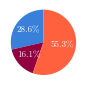

In [29]:
sizes = np.array([46, 26, 89])

fig1, ax1 = plt.subplots(figsize=(1.3,1.3))
ax1.pie(sizes, startangle=90,
        colors=['#3880d9', '#910040', '#ff603d'], autopct='%.1f%%', textprops={'color':"w", 'fontsize': 9, 'weight':'bold'})
ax1.axis('equal')

plt.savefig('fig/subjects.svg', dpi=500, bbox_inches='tight')

### Dropped features

wasi201 ss_blockdesigntscoreperf4 
wasi201 ss_vocabularytscoreverbal4 
wasi201 ss_vocabularytscore2 
wasi201 ss_matrixreasoningtscoreperf4 
wasi201 ss_matrixreasoningtscore2 
wasi201 ss_similaritiestscoreverbal4 
wasi201 sumstscores_verbal4subtest 
wasi201 sumstscores_perf4subtest 
wasi201 sumstscores_total4subtest 
wasi201 sumstscores_total2subtest 
wasi201 iqscores_verbsumtscores 
wasi201 iqscores_verbiq 
wasi201 iqscores_verbpercentile 
wasi201 iqscores_verbconfintervalfrom 
wasi201 iqscores_verbconfintervalto 
wasi201 iqscores_perfsumtscores 
wasi201 iqscores_perfiq 
dccs01 acc 
dccs01 rt
flanker01 acc
flanker01 rt
lswmt01 nih_tlbx_tscore 
lswmt01 nih_tlbx_agegencsc 
lswmt01 nih_tlbx_fctsc 
orrt01 read_fcts 
pcps01 nih_tlbx_fctsc
tpvt01 tlbx_readncorr 
tpvt01 lavoc_screen 
tpvt01 tpvt_fcts 
ymrs01 ymrstot

### Number of missing subjects

In [26]:
for column in df_cog_:
    print(column, df_cog_[column].isna().sum())

phenotype 0
phenotype_description 0
sex 0
interview_age 0
sestot 1
mot_edscale 6
acpt01_auditory_t1 0
acpt01_auditory_t3 0
acpt01_auditory_t4 0
acpt01_auditory_t5 1
acpt01_auditory_t6 0
acpt01_auditory_t8 0
acpt01_auditory_t9 0
acpt01_auditory_t10 2
acpt01_auditory_t11 0
acpt01_auditory_t13 0
acpt01_auditory_t14 0
acpt01_auditory_t15 0
cogcomp01_nih_fluidcogcomp_unadjusted 1
cogcomp01_nih_crycogcomp_unadjusted 0
dccs01_nih_dccs_ageadjusted 0
deldisk01_sv_6mo_40000 0
deldisk01_sv_3yr_40000 0
deldisk01_sv_1mo_40000 0
deldisk01_sv_5yr_40000 0
deldisk01_sv_10yr_40000 0
deldisk01_sv_1yr_40000 0
deldisk01_auc_200 0
deldisk01_auc_40000 0
er4001_er40_c_cr 0
er4001_er40_c_rtcr 0
er4001_er40_c_ang 0
er4001_er40_c_fear 0
er4001_er40_c_hap 0
er4001_er40_c_noe 0
er4001_er40_c_sad 0
er4001_er40_c_fpa 0
er4001_er40_c_fpf 0
er4001_er40_c_fph 0
er4001_er40_c_fpn 0
er4001_er40_c_fps 0
flanker01_nih_flanker_ageadjusted 0
lswmt01_tbx_ls 0
orrt01_read_acss 0
pcps01_nih_patterncomp_ageadjusted 1
tpvt01_tpvt

### Number of missing features

In [33]:
df_cog_.isnull().sum(axis=1)

1010    0
1017    0
1024    0
1026    0
1027    0
1028    0
1052    0
1064    0
1067    0
1078    0
1079    0
1080    0
1081    0
1082    0
1084    0
1085    0
1088    0
1091    0
1093    0
1104    0
2001    0
2004    0
2031    0
2046    0
2048    0
3001    0
3002    0
3026    0
3027    0
3028    0
3030    0
3032    0
3035    0
3039    0
4002    0
4003    0
4006    0
4010    0
4011    0
4012    0
4018    0
4022    0
4047    0
4048    0
4063    1
4072    0
1006    0
1009    0
1012    0
1013    0
1018    0
1019    0
1020    0
1021    0
1022    0
1025    0
1029    0
1030    0
1031    0
1032    0
1033    0
1034    0
1035    0
1036    0
1037    0
1038    0
1039    0
1040    0
1041    0
1043    0
1044    0
1045    0
1047    0
1048    0
1050    0
1051    0
1053    0
1054    0
1056    0
1057    1
1060    0
1061    0
1065    0
1066    0
1068    2
1069    0
1070    0
1071    0
1072    0
1073    0
1074    0
1075    1
1076    0
1077    1
1083    0
1086    0
1087    0
1089    0
1094    0
1095    0


# Overview of Subjects

### Clinical Scores

In [30]:
from scipy.stats import kruskal
from scipy.stats import chi2_contingency

In [31]:
df_dem_cli = df_start.loc[df_cog_.index, ['phenotype', 'phenotype_description', 'sex', 'interview_age']]
convert(df_dem_cli)

In [32]:
df_dem_cli = df_dem_cli.join(socdem[['race']], how='left')

In [33]:
panss = pd.read_csv(path  + 'panss01.txt', sep="\t") #.replace(to_replace=np.NaN, value=0)
panss = panss.drop_duplicates(subset=['subjectkey'], keep='first').iloc[1:]  # drop dublicates and remove description
panss['src_subject_id'] = panss['src_subject_id'].astype(int)
panss = panss.set_index('src_subject_id')  # set index 

In [34]:
total = ['panss_total']
pos = ['pos_p1','pos_p2','pos_p3','pos_p4','pos_p5','pos_p6','pos_p7']
neg = ['neg_n1','neg_n2','neg_n3','neg_n4','neg_n5','neg_n6','neg_n7']
general = ['gps_g1','gps_g2','gps_g3','gps_g4','gps_g5','gps_g6','gps_g7','gps_g8','gps_g9','gps_g10','gps_g11','gps_g12','gps_g13','gps_g14','gps_g15','gps_g16']
all_panss = total + pos +neg + general

In [35]:
df_cli_all = df_start.loc[df_cog_.index, ['phenotype_description']]
df_cli_all = df_cli_all.join(panss[all_panss].astype(float))
convert(df_cli_all, True)
df_cli_all = df_cli_all[df_cli_all.phenotype_description != 0]

In [36]:
aff = df_cli_all.loc[df_cli_all['phenotype_description']==1]
nonaff = df_cli_all.loc[df_cli_all['phenotype_description']==2]

sig = []
for column in df_cli_all.columns[1:]:
    test = sci.stats.kruskal(ana.removenan(aff[column].values), ana.removenan(nonaff[column].values))
    sig.append([column, round(test[0],2), round(test[1],4)])
                             
df = pd.DataFrame(sig, columns= ['feature', 'A - NA stat', 'A - NA p'])
df = df.set_index('feature')

In [37]:
df
# *   P ≤ 0.05
# **  P ≤ 0.01
# *** P ≤ 0.001

,A - NA stat,A - NA p
feature,,
panss_total,12.82,0.0003
pos_p1,12.02,0.0005
pos_p2,4.33,0.0374
pos_p3,7.26,0.0070
pos_p4,1.20,0.2728
pos_p5,3.98,0.0461
pos_p6,1.09,0.2955
pos_p7,0.23,0.6342
neg_n1,13.32,0.0003


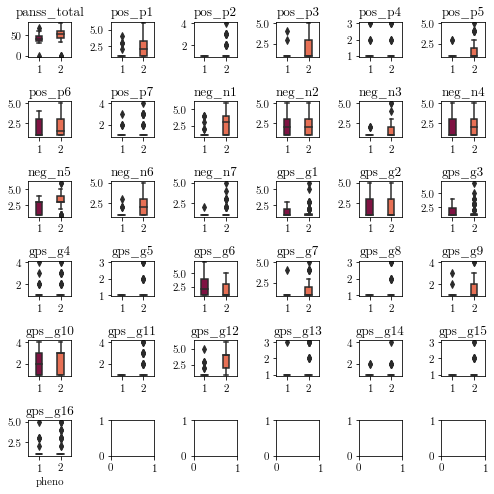

In [38]:
colors = ['#910040', '#ff603d']

fig, ax = plt.subplots(6,6, figsize=(7,7))
for i, col in enumerate(df_cli_all.columns[1:]):
    data = df_cli_all[['phenotype_description', col]]
    data = data.dropna(axis='rows')
    g = sns.boxplot(x='phenotype_description', y=col, data=data, palette=colors, width=0.3, ax=ax.flatten()[i])
    g.set(xlabel='')
    g.set(ylabel='')
    g.set(title=col)
    if i==30:
        g.set(xlabel='pheno')
    
plt.tight_layout()
plt.savefig('fig/panss_boxplot.svg', dpi=500, bbox_inches='tight')

In [39]:
df_dem_cli = df_dem_cli.join(panss[total].astype(float))

pos_df = panss[pos].astype(float)
pos_df['panss_pos'] = pos_df[pos].sum(axis=1)
df_dem_cli = df_dem_cli.join(pos_df['panss_pos'])

neg_df = panss[neg].astype(float)
neg_df['panss_neg'] = neg_df[neg].sum(axis=1)
df_dem_cli = df_dem_cli.join(neg_df['panss_neg'])

general_df = panss[general].astype(float)
general_df['general'] = general_df[general].sum(axis=1)
df_dem_cli = df_dem_cli.join(general_df['general'])

df_dem_cli['interview_age'] = df_dem_cli['interview_age'].div(12)

In [40]:
df_dem_cli.drop(columns=['sex','interview_age','race']).to_csv('../data/clinical.txt', sep=',')

In [41]:
c = df_dem_cli.loc[df_dem_cli['phenotype_description']==0]
a = df_dem_cli.loc[df_dem_cli['phenotype_description']==1]
na = df_dem_cli.loc[df_dem_cli['phenotype_description']==2]

In [42]:
df_dem_cli[['phenotype_description', 'interview_age', 'panss_total','panss_pos', 'panss_neg','general']].groupby('phenotype_description').mean()

,interview_age,panss_total,panss_pos,panss_neg,general
phenotype_description,,,,,
0,24.612319,NaN,NaN,NaN,NaN
1,24.190000,41.080000,8.960000,11.200000,22.280000
2,22.233135,49.797619,11.654762,15.011905,25.285714


In [43]:
df_dem_cli[['phenotype_description', 'interview_age', 'panss_total','panss_pos', 'panss_neg','general']].groupby('phenotype_description').std()

,interview_age,panss_total,panss_pos,panss_neg,general
phenotype_description,,,,,
0,4.064838,NaN,NaN,NaN,NaN
1,3.927845,12.382515,2.540997,3.763863,4.937273
2,3.336414,15.151269,3.916275,5.796746,5.331361


In [44]:
kruskal(c['interview_age'].values, a['interview_age'].values, na['interview_age'].values)

KruskalResult(statistic=14.109409291114456, pvalue=0.0008633376900537498)

In [45]:
kruskal(a['panss_total'].values, na['panss_total'].values)

KruskalResult(statistic=12.82056335172073, pvalue=0.0003428304824392656)

In [46]:
kruskal(a['panss_pos'].values, na['panss_pos'].values)

KruskalResult(statistic=10.941288375883909, pvalue=0.0009404475089921164)

In [47]:
kruskal(a['panss_neg'].values, na['panss_neg'].values)

KruskalResult(statistic=10.645254542580851, pvalue=0.0011035369269110187)

In [48]:
kruskal(a['general'].values, na['general'].values)

KruskalResult(statistic=7.4388028757799045, pvalue=0.006383233605001294)

## Demographics

In [49]:
df_dem_cli.groupby(['phenotype_description', 'sex']).size()

phenotype_description  sex
0                      0      30
                       1      16
1                      0      8 
                       1      17
2                      0      59
                       1      25
dtype: int64

In [50]:
chi2_contingency([[30,16], [8,17], [59,25]])

(12.223744810216392,
 0.0022163969322006186,
 2,
 array([[28.78709677, 17.21290323],
        [15.64516129,  9.35483871],
        [52.56774194, 31.43225806]]))

In [51]:
df_dem_cli.groupby(['phenotype_description', 'race']).size()

phenotype_description  race                         
0                      Asian                            7 
                       Black or African American        4 
                       More than one race               1 
                       Unknown or not reported          2 
                       White                            32
1                      American Indian/Alaska Native    1 
                       Asian                            2 
                       Black or African American        2 
                       White                            20
2                      Asian                            5 
                       Black or African American        42
                       Unknown or not reported          3 
                       White                            33
dtype: int64

In [52]:
chi2_contingency([[7, 4, 1, 32, 0], [2, 2, 0, 20, 1], [5, 42, 0, 33, 0]])

(40.004408422459896,
 3.1976678277432407e-06,
 8,
 array([[ 4.13422819, 14.17449664,  0.29530201, 25.10067114,  0.29530201],
        [ 2.34899329,  8.05369128,  0.16778523, 14.26174497,  0.16778523],
        [ 7.51677852, 25.77181208,  0.53691275, 45.63758389,  0.53691275]]))

### Cognitive Features

In [53]:
cog_mean = df_cog_.drop(columns=['phenotype', 'sex', 'interview_age', 'sestot', 'mot_edscale']).groupby('phenotype_description').mean()
cog_std = df_cog_.drop(columns=['phenotype', 'sex', 'interview_age', 'sestot', 'mot_edscale']).groupby('phenotype_description').std()
cog_std = cog_std.add_suffix('_std') #make it differentiable
cog_mean_std = cog_mean.join(cog_std, how='left')
cog_mean_std = cog_mean_std.round(decimals=2)
cog_mean_std = cog_mean_std.astype(str)

In [54]:
cog_overview = pd.DataFrame()
for column in cog_mean:
    column_std = column + '_std'
    cog_overview[column] = cog_mean_std[[column, column_std]].apply(lambda x: ', '.join(x), axis=1)

In [55]:
cog_overview

,acpt01_auditory_t1,acpt01_auditory_t3,acpt01_auditory_t4,acpt01_auditory_t5,acpt01_auditory_t6,acpt01_auditory_t8,acpt01_auditory_t9,acpt01_auditory_t10,acpt01_auditory_t11,acpt01_auditory_t13,acpt01_auditory_t14,acpt01_auditory_t15,cogcomp01_nih_fluidcogcomp_unadjusted,cogcomp01_nih_crycogcomp_unadjusted,dccs01_nih_dccs_ageadjusted,deldisk01_sv_6mo_40000,deldisk01_sv_3yr_40000,deldisk01_sv_1mo_40000,deldisk01_sv_5yr_40000,deldisk01_sv_10yr_40000,deldisk01_sv_1yr_40000,deldisk01_auc_200,deldisk01_auc_40000,er4001_er40_c_cr,er4001_er40_c_rtcr,er4001_er40_c_ang,er4001_er40_c_fear,er4001_er40_c_hap,er4001_er40_c_noe,er4001_er40_c_sad,er4001_er40_c_fpa,er4001_er40_c_fpf,er4001_er40_c_fph,er4001_er40_c_fpn,er4001_er40_c_fps,flanker01_nih_flanker_ageadjusted,lswmt01_tbx_ls,orrt01_read_acss,pcps01_nih_patterncomp_ageadjusted,tpvt01_tpvt_acss,wasi201_vocab_totalrawscore,wasi201_matrix_totalrawscore,wasi201_iqscores_full2iq
phenotype_description,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,"21.22, 2.14","0.28, 0.66","88.41, 8.97","597.13, 88.05","35.28, 1.83","1.41, 6.64","97.91, 5.2","603.3, 92.18","31.76, 3.74","1.37, 1.32","88.0, 10.41","667.26, 75.42","112.63, 9.82","110.26, 7.6","99.7, 17.15","33641.3, 7982.52","23097.83, 13151.07","35461.96, 7744.21","21168.48, 12615.17","16630.43, 14121.54","29211.96, 12037.58","0.26, 0.25","0.56, 0.28","36.09, 1.85","1735.23, 325.38","6.72, 1.11","7.37, 0.8","7.98, 0.15","7.35, 0.97","6.67, 0.99","0.61, 0.88","0.89, 1.04","0.17, 0.38","1.54, 1.41","0.7, 1.05","88.35, 13.51","19.15, 2.72","116.83, 16.61","104.96, 19.65","113.59, 13.94","43.57, 4.28","23.59, 2.46","115.87, 10.85"
1,"19.64, 3.2","0.44, 0.92","81.76, 13.25","584.8, 110.24","34.68, 1.84","1.24, 2.37","96.24, 5.09","610.92, 78.44","29.2, 4.64","3.16, 6.77","78.0, 19.46","684.48, 111.56","109.36, 10.11","108.2, 7.07","93.08, 13.67","31775.0, 10926.6","21275.0, 14573.45","32675.0, 10985.79","20325.0, 15074.81","17175.0, 14614.31","26575.0, 12931.51","0.29, 0.25","0.53, 0.32","35.16, 2.66","1994.82, 408.78","6.92, 1.0","6.88, 1.51","7.84, 0.37","7.2, 0.71","6.32, 1.28","0.68, 0.85","0.96, 1.17","0.36, 0.49","1.76, 1.85","1.08, 1.19","82.52, 11.33","19.08, 1.98","112.4, 17.67","103.08, 26.19","110.0, 12.36","41.84, 6.07","22.28, 2.26","109.64, 11.58"
2,"17.96, 4.33","1.67, 2.87","74.41, 18.23","662.77, 148.11","32.43, 5.76","2.6, 7.83","89.71, 16.09","630.55, 117.81","24.45, 7.06","5.55, 10.13","67.75, 19.63","741.68, 119.69","96.24, 14.16","101.39, 10.6","82.42, 19.77","26666.67, 14149.9","16994.05, 14415.86","29598.21, 13352.22","13035.71, 14091.17","10282.74, 13002.48","19226.19, 14827.58","0.23, 0.24","0.38, 0.3","33.49, 3.7","2256.48, 594.7","6.31, 1.3","6.61, 1.5","7.83, 0.37","6.82, 1.61","5.92, 1.84","0.89, 1.42","1.37, 1.92","0.6, 1.48","2.68, 2.5","0.98, 1.17","75.82, 17.67","16.24, 3.77","102.38, 21.85","88.92, 19.52","98.42, 17.9","37.42, 7.35","19.62, 4.86","99.24, 16.85"


### Group comparison

In [56]:
cog_comparison = ana.group_comparison(df_cog_, cog_overview)
cog_comparison

,acpt01_auditory_t1,acpt01_auditory_t3,acpt01_auditory_t4,acpt01_auditory_t5,acpt01_auditory_t6,acpt01_auditory_t8,acpt01_auditory_t9,acpt01_auditory_t10,acpt01_auditory_t11,acpt01_auditory_t13,acpt01_auditory_t14,acpt01_auditory_t15,cogcomp01_nih_fluidcogcomp_unadjusted,cogcomp01_nih_crycogcomp_unadjusted,dccs01_nih_dccs_ageadjusted,deldisk01_sv_6mo_40000,deldisk01_sv_3yr_40000,deldisk01_sv_1mo_40000,deldisk01_sv_5yr_40000,deldisk01_sv_10yr_40000,deldisk01_sv_1yr_40000,deldisk01_auc_200,deldisk01_auc_40000,er4001_er40_c_cr,er4001_er40_c_rtcr,er4001_er40_c_ang,er4001_er40_c_fear,er4001_er40_c_hap,er4001_er40_c_noe,er4001_er40_c_sad,er4001_er40_c_fpa,er4001_er40_c_fpf,er4001_er40_c_fph,er4001_er40_c_fpn,er4001_er40_c_fps,flanker01_nih_flanker_ageadjusted,lswmt01_tbx_ls,orrt01_read_acss,pcps01_nih_patterncomp_ageadjusted,tpvt01_tpvt_acss,wasi201_vocab_totalrawscore,wasi201_matrix_totalrawscore,wasi201_iqscores_full2iq
test,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
group,"[23.2798, 0.0]","[14.0065, 0.0009]","[23.7784, 0.0]","[8.8155, 0.0122]","[22.6189, 0.0]","[12.3265, 0.0021]","[22.8805, 0.0]","[1.6303, 0.4426]","[37.9259, 0.0]","[12.8582, 0.0016]","[36.3871, 0.0]","[14.2833, 0.0008]","[44.3346, 0.0]","[24.3399, 0.0]","[25.2977, 0.0]","[7.6215, 0.0221]","[5.8105, 0.0547]","[7.8966, 0.0193]","[13.215, 0.0014]","[11.3935, 0.0034]","[15.4713, 0.0004]","[2.9605, 0.2276]","[13.603, 0.0011]","[21.1553, 0.0]","[35.4447, 0.0]","[5.5816, 0.0614]","[8.2937, 0.0158]","[6.1526, 0.0461]","[3.2871, 0.1933]","[4.7781, 0.0917]","[0.5384, 0.764]","[2.3732, 0.3053]","[4.9563, 0.0839]","[6.7504, 0.0342]","[2.8311, 0.2428]","[24.1251, 0.0]","[24.8166, 0.0]","[14.4173, 0.0007]","[19.7444, 0.0001]","[24.3539, 0.0]","[26.2923, 0.0]","[26.7291, 0.0]","[33.6833, 0.0]"
contr - affect.,"[3.4085, 0.0598]","[0.6283, 0.5464]","[4.3254, 0.0445]","[0.4149, 0.5209]","[4.8816, 0.058]","[0.8618, 0.345]","[4.8203, 0.0626]",-,"[5.188, 0.0482]","[0.4629, 0.4164]","[5.9571, 0.0246]","[0.0943, 0.6356]","[0.3142, 0.5771]","[1.4102, 0.3646]","[2.1767, 0.2437]","[0.3606, 0.5733]",-,"[1.7217, 0.2524]","[0.0741, 0.6531]","[0.0003, 0.9798]","[0.8449, 0.3923]",-,"[0.0305, 0.7058]","[1.6085, 0.2123]","[8.2098, 0.0126]",-,"[0.9765, 0.2865]","[4.6632, 0.0908]",-,-,-,-,-,"[0.0503, 0.7988]",-,"[3.6913, 0.1207]","[0.0003, 0.8765]","[0.7755, 0.422]","[0.0192, 0.6357]","[1.4513, 0.383]","[0.7344, 0.3725]","[5.4396, 0.0583]","[4.1971, 0.0871]"
contr - non-aff.,"[23.2309, 0.0]","[11.9591, 0.0004]","[23.3648, 0.0]","[5.0166, 0.026]","[21.8255, 0.0]","[11.8207, 0.0006]","[21.9605, 0.0]",-,"[35.3301, 0.0]","[12.3302, 0.0005]","[34.9359, 0.0]","[12.8604, 0.0004]","[37.1837, 0.0]","[20.9466, 0.0]","[22.34, 0.0]","[6.9097, 0.0082]",-,"[7.6219, 0.0051]","[11.9557, 0.0007]","[8.9491, 0.0029]","[14.0943, 0.0002]",-,"[12.138, 0.0007]","[20.0017, 0.0]","[33.4588, 0.0]",-,"[8.3973, 0.0042]","[6.0693, 0.0163]",-,-,-,-,-,"[5.7847, 0.0167]",-,"[21.9169, 0.0]","[17.9465, 0.0]","[13.0341, 0.0003]","[18.0391, 0.0]","[20.6755, 0.0]","[23.7541, 0.0]","[24.494, 0.0]","[30.7867, 0.0]"
affect - non-aff.,"[3.1561, 0.0697]","[4.5075, 0.0287]","[3.1093, 0.0846]","[6.2788, 0.0127]","[3.2113, 0.0807]","[2.5824, 0.0844]","[3.4518, 0.0715]",-,"[8.4391, 0.0063]","[3.234, 0.0578]","[6.1622, 0.0177]","[4.9124, 0.0204]","[18.4898, 0.0]","[8.743, 0.0053]","[7.9686, 0.0083]","[2.297, 0.1299]",-,"[1.0929, 0.3138]","[4.6012, 0.0254]","[5.7259, 0.0178]","[4.6108, 0.0347]",-,"[4.8651, 0.0198]","[5.0784, 0.0244]","[5.2203, 0.0393]",-,"[1.1213, 0.2543]","[0.0062, 0.9291]",-,-,-,-,-,"[2.6223, 0.099]",-,"[5.8733, 0.0277]","[13.7723, 0.0003]","[4.4286, 0.0395]","[6.6929, 0.0055]","[9.1081, 0.0048]","[8.5215, 0.0033]","[5.3978, 0.0388]","[8.5076, 0.0066]"


In [57]:
cog_table = pd.concat([cog_overview, cog_comparison]).T
#print(cog_table.to_latex(index=True))  

# Replacing missing data

In [58]:
missing = ['phenotype',
          'acpt01_auditory_t5', 'acpt01_auditory_t10', 'cogcomp01_nih_fluidcogcomp_unadjusted',
          'pcps01_nih_patterncomp_ageadjusted', ]

In [59]:
miss_mean = df_cog_[missing].groupby('phenotype').mean()
miss_std = df_cog_[missing].groupby('phenotype').std()
miss_std = miss_std.add_suffix('_std') #make it differentiable
miss_mean_std = miss_mean.join(miss_std, how='left')
miss_mean_std = miss_mean_std.round(decimals=2)
miss_mean_std = miss_mean_std.astype(str)

In [60]:
miss_overview = pd.DataFrame()
for column in miss_mean:
    column_std = column + '_std'
    miss_overview[column] = miss_mean_std[[column, column_std]].apply(lambda x: ', '.join(x), axis=1)

In [61]:
miss_overview

,acpt01_auditory_t5,acpt01_auditory_t10,cogcomp01_nih_fluidcogcomp_unadjusted,pcps01_nih_patterncomp_ageadjusted
phenotype,,,,
0,"597.13, 88.05","603.3, 92.18","112.63, 9.82","104.96, 19.65"
1,"644.72, 143.62","625.96, 109.85","99.28, 14.4","92.19, 21.95"


In [62]:
print(df_cog_['mot_edscale'].loc[df_cog_['phenotype'].isin([1])].mode(1))
print(df_cog_['mot_edscale'].loc[df_cog_['phenotype'].isin([0])].mode(1))

0    6.0
dtype: float64
0    6.0
dtype: float64


In [63]:
print(df_cog_['sestot'].loc[df_cog_['phenotype'].isin([1])].mode(1))
print(df_cog_['sestot'].loc[df_cog_['phenotype'].isin([0])].mode(1))

0    2.0
dtype: float64
0    2.0
dtype: float64


In [64]:
mean_patients = df_cog_.drop(columns=['sestot', 'mot_edscale']).loc[df_cog_['phenotype'].isin([1])].mean()
df_cog_ = df_cog_.fillna(mean_patients)  # only patient data is missing cognitive features
df_cog_['sestot'] =  df_cog_['sestot'].fillna(2)
df_cog_['mot_edscale'] =  df_cog_['mot_edscale'].fillna(6)

# Preprocessing

In [65]:
import sklearn.preprocessing as prepro

In [66]:
# features to be z-scored
df_cog_col = list(df_cog_.columns)[3:] # remove phenotype, phenotype_description, sex
del df_cog_col[1:3]  # remove 'sestot', 'mot_edscale'

In [67]:
df_cog_ = df_cog_.sort_values(by='phenotype_description')

In [68]:
df_index = df_cog_.index  # subjets for which behavioral data is avalible
brain_data_ = brain_data.filter(items = df_index, axis=0)

### z-score

In [69]:
df_cog_zscore = df_cog_.copy()

for column in df_cog_col:
        df_cog_zscore[column] = (df_cog_zscore[column] - df_cog_zscore[column].mean()) / df_cog_zscore[column].std()

In [70]:
df_cog_zscore[column] = (df_cog_zscore[column] - df_cog_zscore[column].mean()) / df_cog_zscore[column].std()

In [71]:
for column in ['sestot', 'mot_edscale']:
        df_cog_zscore[column] = (df_cog_zscore[column] - df_cog_zscore[column].min()) / (df_cog_zscore[column].max()-df_cog_zscore[column].min())

In [72]:
df_cog_zscore.head(10)

,phenotype,phenotype_description,sex,interview_age,sestot,mot_edscale,acpt01_auditory_t1,acpt01_auditory_t3,acpt01_auditory_t4,acpt01_auditory_t5,acpt01_auditory_t6,acpt01_auditory_t8,acpt01_auditory_t9,acpt01_auditory_t10,acpt01_auditory_t11,acpt01_auditory_t13,acpt01_auditory_t14,acpt01_auditory_t15,cogcomp01_nih_fluidcogcomp_unadjusted,cogcomp01_nih_crycogcomp_unadjusted,dccs01_nih_dccs_ageadjusted,deldisk01_sv_6mo_40000,deldisk01_sv_3yr_40000,deldisk01_sv_1mo_40000,deldisk01_sv_5yr_40000,deldisk01_sv_10yr_40000,deldisk01_sv_1yr_40000,deldisk01_auc_200,deldisk01_auc_40000,er4001_er40_c_cr,er4001_er40_c_rtcr,er4001_er40_c_ang,er4001_er40_c_fear,er4001_er40_c_hap,er4001_er40_c_noe,er4001_er40_c_sad,er4001_er40_c_fpa,er4001_er40_c_fpf,er4001_er40_c_fph,er4001_er40_c_fpn,er4001_er40_c_fps,flanker01_nih_flanker_ageadjusted,lswmt01_tbx_ls,orrt01_read_acss,pcps01_nih_patterncomp_ageadjusted,tpvt01_tpvt_acss,wasi201_vocab_totalrawscore,wasi201_matrix_totalrawscore,wasi201_iqscores_full2iq
1010,0,0,0,0.677291,0.00,0.666667,0.719724,-0.466422,0.747283,-0.379579,0.513235,-0.294886,0.527506,0.428788,1.280175,-0.481063,1.263284,-0.459052,1.985641,0.680216,2.225363,0.787117,1.218434,0.639119,1.241682,1.247383,1.109067,-0.097624,1.355674,-0.160525,-0.455035,-0.434196,0.089844,0.372565,-0.028823,-0.130845,1.018440,-0.100460,0.498143,-0.088523,-0.796775,1.839759,1.537035,0.709581,1.185320,0.299544,0.438681,1.108016,0.993161
3001,0,0,0,0.633513,0.00,1.000000,0.462680,-0.466422,0.503197,-0.356620,0.513235,-0.294886,0.527506,-0.596201,1.280175,-0.358424,1.263284,-0.450115,0.328610,0.779121,0.190070,0.787117,1.393707,0.639119,1.591451,1.517041,1.109067,2.736771,1.614511,1.356636,-0.693871,1.207277,0.822784,0.372565,0.715771,0.502934,-0.643226,-0.723308,-0.379268,-0.545889,-0.796775,0.810291,-0.158626,0.998888,1.185320,0.299544,0.294623,1.108016,0.685650
3002,0,0,0,3.260203,0.00,1.000000,-0.308453,-0.466422,-0.290082,-0.149987,0.078528,-0.003757,0.062060,-0.069337,-0.652074,-0.358424,-0.586394,-0.083716,0.190524,1.372555,-0.471400,0.787117,-1.323033,0.639119,-1.119263,-0.909877,1.109067,-0.406130,-0.801296,0.749771,-0.589950,-0.434196,0.822784,0.372565,0.715771,0.502934,-0.643226,0.522389,-0.379268,-0.545889,-0.796775,0.749734,0.123984,0.902453,0.638630,0.989089,0.870856,0.179678,0.439642
3026,0,0,1,2.866199,0.00,0.666667,0.462680,-0.466422,0.442176,-0.777539,0.513235,-0.294886,0.527506,-0.471670,-0.057536,-0.358424,-0.021215,-0.208828,0.604782,-0.012124,0.088305,0.787117,-1.323033,0.639119,-1.119263,-0.909877,-1.576955,-0.816400,-1.194626,1.053204,-1.248116,1.207277,0.089844,0.372565,-0.028823,1.136714,0.187607,-0.723308,-0.379268,-1.003256,0.079112,0.689177,-0.441237,-0.110123,1.413108,-0.217614,1.158973,-0.052406,0.562646
3027,0,0,0,0.436511,0.00,1.000000,0.462680,-0.466422,0.442176,-1.037744,0.513235,-0.294886,0.527506,-1.247597,0.239733,-0.358424,0.235685,-1.308026,1.640426,0.976933,1.869187,0.085373,-0.008481,0.533169,0.104931,-0.640219,1.109067,-0.842108,0.041191,0.142907,-1.392146,0.386541,0.822784,0.372565,-1.518011,0.502934,1.849273,-0.723308,0.498143,-1.003256,0.079112,1.113076,1.254425,0.998888,1.868683,1.046551,0.438681,1.340100,1.239170
3030,0,0,0,0.173842,0.25,0.833333,0.462680,-0.466422,0.503197,-0.127027,0.295881,-0.294886,0.294783,0.409630,0.537002,-0.358424,0.543964,-0.235637,-0.016605,1.174744,-0.166106,-0.716619,-1.060122,-0.208483,-0.856935,-0.909877,-0.970434,-0.808366,-1.031796,0.749771,-0.511553,1.207277,-0.643096,0.372565,0.715771,0.502934,-0.643226,-0.723308,-0.379268,-0.088523,0.079112,-0.219177,0.123984,1.577503,0.365285,1.046551,0.006506,-0.052406,-0.236883
3032,0,0,0,0.195731,0.50,0.666667,-0.051409,-0.466422,-0.045996,-0.869376,0.513235,-0.149321,0.527506,-0.500408,-0.057536,-0.113145,-0.021215,-1.325899,0.328610,-0.209935,-0.166106,0.085373,-1.147759,0.639119,-0.856935,-0.909877,-0.190621,-0.738202,-0.877002,-0.463958,-0.028412,-0.434196,0.822784,0.372565,-1.518011,-0.130845,0.187607,-0.100460,-0.379268,-0.088523

In [73]:
brain_data_zscore = brain_data_.copy()

for column in list(brain_data.columns):
        brain_data_zscore[column] = (brain_data_zscore[column] - brain_data_zscore[column].mean()) / brain_data_zscore[column].std()

In [74]:
brain_data_zscore.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
HCP_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1010,0.619465,0.189746,-0.364010,-0.132388,0.277421,1.271392,1.066124,0.466515,-1.171576,0.203701,0.723493,0.471083,1.749910,-1.824533,0.541201,-0.919531,-0.769308,-0.683972,-0.592951,1.027369,1.219660,-0.567006,-1.714163,-0.003778,0.470635,-0.960043,-1.350041,1.894925,0.187755,-1.012922
3001,1.163416,0.977154,1.027564,1.074813,1.369661,1.005035,1.180945,1.349046,0.607018,0.108293,-1.612112,-0.979145,-1.321946,0.780130,1.052170,-1.985288,-1.572206,-0.567676,-1.013057,0.208805,0.423166,-1.659470,-0.559409,1.572050,0.074857,-1.795608,-1.746027,1.596271,-2.048025,-0.688963
3002,-0.315166,-1.661392,-1.445195,-0.551861,-1.220025,-1.711740,-1.174791,-1.879101,1.345422,0.522087,0.010210,1.277263,0.749398,2.028729,0.024220,-1.120158,-0.271657,1.030128,-0.030961,1.536524,-0.937341,2.146894,1.238820,1.391882,0.188792,0.528338,1.142476,-0.172847,0.254376,-1.366535
3026,-0.463797,-1.438082,-1.576724,-1.896329,-1.381476,1.479079,-0.569325,-1.199177,1.233014,-0.147655,-0.201031,0.351909,1.681407,-0.225860,-0.012491,1.434019,0.837575,-1.351532,0.743440,0.225915,1.470244,1.213470,1.298629,0.655640,-0.782557,1.401913,0.596596,-1.071454,0.586616,-0.828377
3027,-0.511272,-0.864259,0.647120,-0.307853,-0.396780,0.621005,-0.703509,-0.662776,-0.224798,3.062101,-1.121013,1.095392,-1.341227,3.527088,0.693480,-0.759852,0.073165,-0.764066,0.004636,-1.179601,-0.094037,-1.013502,-0.687267,0.750777,0.847980,-1.296956,1.310148,0.719352,-1.168373,-0.992980


### Quantile Normalization

In [75]:
df = df_cog_[['phenotype', 'phenotype_description', 'sex', 'sestot', 'mot_edscale']].copy()
df_ = df_cog_.drop(columns=['phenotype', 'phenotype_description', 'sex', 'sestot', 'mot_edscale'])

qt = prepro.QuantileTransformer(n_quantiles=100)
q_features = qt.fit_transform(df_)
df_cog_quant = pd.DataFrame(data=q_features, index=df_cog_.index, columns=df_cog_col, dtype=float)

df_cog_quant = df.join(pd.DataFrame(df_cog_quant))

In [76]:
for column in ['sestot', 'mot_edscale']:
        df_cog_quant[column] = (df_cog_[column] - df_cog_[column].min()) / (df_cog_[column].max()-df_cog_zscore[column].min())

In [77]:
df_cog_quant.head()

,phenotype,phenotype_description,sex,sestot,mot_edscale,interview_age,acpt01_auditory_t1,acpt01_auditory_t3,acpt01_auditory_t4,acpt01_auditory_t5,acpt01_auditory_t6,acpt01_auditory_t8,acpt01_auditory_t9,acpt01_auditory_t10,acpt01_auditory_t11,acpt01_auditory_t13,acpt01_auditory_t14,acpt01_auditory_t15,cogcomp01_nih_fluidcogcomp_unadjusted,cogcomp01_nih_crycogcomp_unadjusted,dccs01_nih_dccs_ageadjusted,deldisk01_sv_6mo_40000,deldisk01_sv_3yr_40000,deldisk01_sv_1mo_40000,deldisk01_sv_5yr_40000,deldisk01_sv_10yr_40000,deldisk01_sv_1yr_40000,deldisk01_auc_200,deldisk01_auc_40000,er4001_er40_c_cr,er4001_er40_c_rtcr,er4001_er40_c_ang,er4001_er40_c_fear,er4001_er40_c_hap,er4001_er40_c_noe,er4001_er40_c_sad,er4001_er40_c_fpa,er4001_er40_c_fpf,er4001_er40_c_fph,er4001_er40_c_fpn,er4001_er40_c_fps,flanker01_nih_flanker_ageadjusted,lswmt01_tbx_ls,orrt01_read_acss,pcps01_nih_patterncomp_ageadjusted,tpvt01_tpvt_acss,wasi201_vocab_totalrawscore,wasi201_matrix_totalrawscore,wasi201_iqscores_full2iq
1010,0,0,0,0.0,0.571429,0.785714,0.742424,0.0,0.777778,0.404040,1.000000,0.00000,1.000000,0.676768,1.000000,0.000000,1.000000,0.350842,1.000000,0.732323,0.989899,1.000000,0.823232,1.000000,0.800000,0.818182,1.0,0.650206,0.838273,0.363636,0.354278,0.303030,0.429293,1.0,0.363636,0.373737,0.863636,0.550505,0.828283,0.590909,0.000000,0.960089,0.964646,0.712121,0.838384,0.560606,0.641414,0.929293,0.838384
3001,0,0,0,0.0,0.857143,0.767677,0.590909,0.0,0.626263,0.434343,1.000000,0.00000,1.000000,0.310023,1.000000,0.363636,1.000000,0.363636,0.606061,0.782828,0.571429,1.000000,1.000000,1.000000,1.000000,0.843434,1.0,0.957440,0.925178,1.000000,0.221657,1.000000,1.000000,1.0,1.000000,0.651515,0.000000,0.000000,0.000000,0.328283,0.000000,0.792208,0.363636,0.823232,0.838384,0.560606,0.560606,0.929293,0.752525
3002,0,0,0,0.0,0.857143,1.000000,0.313131,0.0,0.323232,0.493857,0.277778,0.80303,0.282828,0.525455,0.227273,0.363636,0.232323,0.505051,0.530303,0.939394,0.358586,1.000000,0.000000,1.000000,0.000000,0.000000,1.0,0.469750,0.284973,0.772727,0.292477,0.303030,1.000000,1.0,1.000000,0.651515,0.000000,0.803030,0.000000,0.328283,0.000000,0.772727,0.510101,0.799327,0.772727,0.818182,0.813131,0.479798,0.621212
3026,0,0,1,0.0,0.571429,0.983881,0.590909,0.0,0.565657,0.217631,1.000000,0.00000,1.000000,0.353535,0.434343,0.363636,0.444444,0.454545,0.747475,0.439394,0.545455,1.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.141677,0.136364,0.914141,0.033816,1.000000,0.429293,1.0,0.363636,1.000000,0.686869,0.000000,0.000000,0.000000,0.611111,0.752525,0.267677,0.424242,0.884848,0.400000,0.914141,0.363636,0.671717
3027,0,0,0,0.0,0.857143,0.707792,0.590909,0.0,0.565657,0.104003,1.000000,0.00000,1.000000,0.090909,0.555556,0.363636,0.560606,0.082386,0.959596,0.828283,0.959596,0.383838,0.500000,0.469697,0.540404,0.424242,1.0,0.088068,0.566800,0.469697,0.018892,0.606061,1.000000,1.0,0.080808,0.651515,0.949495,0.000000,0.828283,0.000000,0.611111,0.888889,0.909091,0.823232,0.980519,0.843434,0.641414,0.964646,0.909091


In [78]:
qt = prepro.QuantileTransformer(n_quantiles=100)
q_features = qt.fit_transform(brain_data_)
brain_data_quant = pd.DataFrame(data=q_features, index=brain_data_.index, columns=list(brain_data_.columns), dtype=float)

In [79]:
brain_data_quant.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
HCP_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1010,0.715675,0.630065,0.330702,0.436240,0.622735,0.889327,0.874810,0.668058,0.130807,0.597171,0.767270,0.719654,0.951603,0.020052,0.724244,0.161930,0.221674,0.264061,0.254109,0.828344,0.895856,0.262212,0.034853,0.539615,0.718541,0.172458,0.090909,0.970183,0.550091,0.176895
3001,0.893719,0.836468,0.869275,0.868917,0.939718,0.845785,0.909091,0.909091,0.745640,0.579734,0.046826,0.168539,0.077845,0.807238,0.826896,0.025586,0.053662,0.318560,0.126656,0.613833,0.697714,0.039687,0.280983,0.944364,0.545455,0.027206,0.059755,0.939572,0.036327,0.266471
3002,0.374299,0.032112,0.075285,0.276956,0.090909,0.016133,0.080512,0.033145,0.909091,0.676714,0.474262,0.890317,0.736712,0.959484,0.490917,0.123934,0.409436,0.836740,0.480153,0.946279,0.150413,1.000000,0.877115,0.909549,0.595072,0.727273,0.878023,0.465435,0.576529,0.101265
3026,0.288700,0.064762,0.040159,0.019840,0.072500,0.921243,0.262601,0.110734,0.858184,0.488493,0.397989,0.666663,0.942010,0.429476,0.473838,0.940102,0.787365,0.066463,0.766259,0.622341,0.929671,0.880985,0.890121,0.747136,0.199234,0.929257,0.739045,0.101797,0.746697,0.221653
3027,0.272727,0.169325,0.714679,0.344791,0.332391,0.746906,0.219010,0.253770,0.415958,1.000000,0.142589,0.858762,0.072260,1.000000,0.755865,0.226716,0.582694,0.227378,0.493962,0.090909,0.485622,0.162296,0.252645,0.784187,0.841104,0.097051,0.897709,0.739042,0.121677,0.188062


# Saving Dataframes

In [272]:
df_cog_zscore = df_cog_zscore.drop(columns=['phenotype', 'phenotype_description'])
df_cog_quant = df_cog_quant.drop(columns=['phenotype', 'phenotype_description'])

df_subj_description = df_cog_[['phenotype', 'phenotype_description']].copy()

In [273]:
brain_data_.to_csv('../data/brain_data.txt', sep=',')
df_cog_.drop(columns=['phenotype', 'phenotype_description']).to_csv('../data/cog_data.txt', sep=',')
df_subj_description.to_csv('../data/subj_description.txt', sep=',')

df_cog_zscore.to_csv('../data_zscore/cog_data.txt', sep=',')
brain_data_zscore.to_csv('../data_zscore/brain_data.txt', sep=',')
df_subj_description.to_csv('../data_zscore/subj_description.txt', sep=',')

df_cog_quant.to_csv('../data_quant/cog_data.txt', sep=',')
brain_data_quant.to_csv('../data_quant/brain_data.txt', sep=',')
df_subj_description.to_csv('../data_quant/subj_description.txt', sep=',')